# Tully-Fisher Secondary Target Sample: Coma Cluster

Access secondary PV survey targets intended for TF measurements.

Grab the targets from the Coma cluster.

In [1]:
import os
import requests

from astropy.io import fits
from astropy.table import join, Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import sys
sys.path.insert(1, '{}/desi/DESI_SGA/'.format(os.environ['HOME']))
try:
    from plot_funcs import plot_radec_DESI
except ModuleNotFoundError as e:
    print(e)
    
import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Postgres Query

See if we have a cached copy of the query results (in FITS format) before running this query.

For connecting to the database, it is recommended that you store the password and connection port in a secure `.pgpass` file on the system or create a private INI file that is not committed to GitHub.  Connection details are not going to be saved in this notebook.  Ask on the `#timedomain-general` or `#peculiar-velocity` or `#transients-lowzcosmo-general` slack channels for more information.

See the [database wiki page](https://desi.lbl.gov/trac/wiki/DESIDatabase) for information about the location and names of tables and their schema.

In [4]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('cache/tf_targets_everest.fits') and use_cached:
    tf_targets = Table.read('cache/tf_targets_everest.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()
        
        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.fiber_ra, fd.fiber_dec, fd.fiberstatus, fd.tileid, zd.target_ra, zd.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn
                   FROM everest.ztile_cumulative_fibermap fd
                   INNER JOIN
                       everest.ztile_cumulative_redshifts zd ON zd.targetid = fd.targetid
                   INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(zd.target_ra*10000 AS INTEGER)) AND 
                                                 (CAST(pr.dec*10000 AS INTEGER) = CAST(zd.target_dec*10000 AS INTEGER))
                   WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA');"""
        
        cursor.execute(query)
        rows = cursor.fetchall()
        tf_targets = Table(list(map(list, zip(*rows))), 
                           names=['PVTYPE', 'SGA_ID', 'TARGETID', 'FIBER_RA', 'FIBER_DEC', 'FIBERSTATUS', 'TILEID', 
                                  'TARGET_RA', 'TARGET_DEC', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
        tf_targets.write('cache/tf_targets_everest.fits', overwrite=True)
        
    except (Exception, psycopg2.errors) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
tf_targets

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64
EXT,17643,39633062056692288,0.0,0.0,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163671928495,39.2330481232594,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163676763292,39.2330716810911,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687172584,39.2330595735952,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687272099,39.2330517354585,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163687614895,39.2330239448729,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163692746003,39.2330238257014,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702566258,39.2330592761066,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0
EXT,17643,39633062056692288,115.163702811737,39.2330394673576,0,80618,115.163713024568,39.2330431988692,0.0112272729370015,2.54691135614028e-06,GALAXY,199710.72255059,0


In [5]:
if 'FIBERSTATUS' in tf_targets.colnames:
    tf_targets = tf_targets[tf_targets['FIBERSTATUS'] == 0]
    print(len(tf_targets))

46307


In [ ]:
match = []
SGA_ids = list(disttab['SGA_ID'])
for l_id in l:
    for SGA_id in SGA_ids:
        if SGA_id == l_id:
            print(SGA_id)
            match.append(SGA_id)

In [6]:
np.unique(tf_targets['PVTYPE'], return_counts=True)

(<Column name='PVTYPE' dtype='bytes3' length=3>
 EXT
 SGA
 TFT,
 array([ 1299, 14686, 30322]))

In [7]:
coma_cluster = ((tf_targets['TILEID'] <= 135) & (tf_targets['TILEID'] >= 109)) | ((tf_targets['TILEID'] <= 456) & (tf_targets['TILEID'] >= 454))

np.sum(coma_cluster)

tf_coma_targets = tf_targets[coma_cluster]

## Plot target coordinates

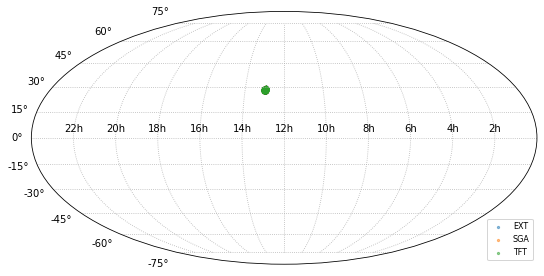

In [8]:
fig = plot_radec_DESI(tf_coma_targets)

## Plot target redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [9]:
isgoodz = (tf_coma_targets['DELTACHI2'] >= 25) & (tf_coma_targets['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0

tf_coma_targets = tf_coma_targets[isgoodz]
np.sum(isgoodz)

1375

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


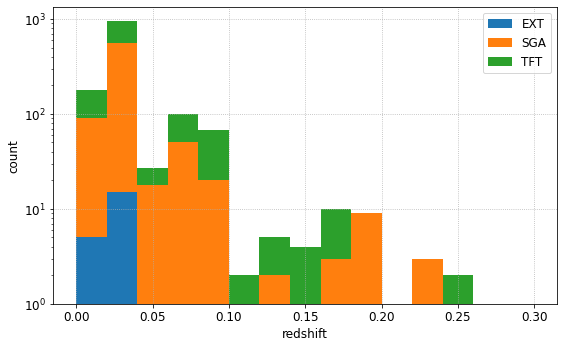

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []

pvtypes = np.unique(tf_coma_targets['PVTYPE'])

for pvtype in pvtypes:
    
    ispvtype = tf_coma_targets['PVTYPE'] == pvtype
    
    zdata.append(list(tf_coma_targets['Z'][ispvtype]))
    
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)

ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Count SGA galaxies with more than one observation

In [11]:
ids, counts = np.unique(tf_coma_targets['SGA_ID'], return_counts=True)
ids[counts > 1]

848
6443
8032
10133
15809
20886
23552
25532
26199
30149
32484


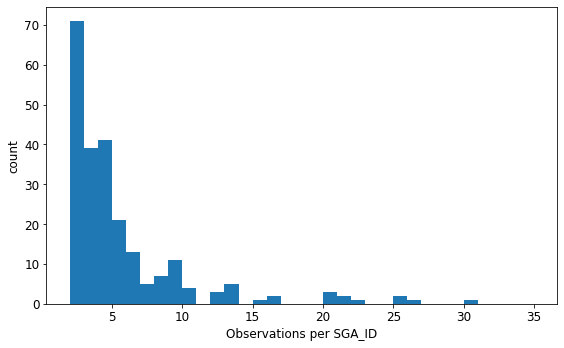

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(counts[counts > 1], bins=np.linspace(2,35,34))

ax.set(xlabel='Observations per SGA_ID', 
       ylabel='count');

In [13]:
# Keep only those with more than one observation
high_count_sga = np.in1d(tf_coma_targets['SGA_ID'], ids[counts > 1])
tf_coma_multiple = tf_coma_targets[high_count_sga]
tf_coma_multiple

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64
EXT,188925,1070786097971202,193.658786680663,28.9301949759371,0,128,193.658794985168,28.9301636891443,0.00777015714518504,1.28926999325833e-05,GALAXY,95.4629959425074,0
EXT,188925,1083980237504514,193.658786221527,28.9301673252834,0,119,193.658794985168,28.9301636891443,0.00776519502981888,8.32506547625627e-06,GALAXY,629.938170446549,0
EXT,188925,1083980237504515,193.680098739232,28.9466762061603,0,114,193.680147147046,28.9466458254239,0.00891610010101787,6.86421809966094e-06,GALAXY,802.309470949695,0
EXT,188925,1083980237504515,193.680186839902,28.9466270913557,0,114,193.680147147046,28.9466458254239,0.00891610010101787,6.86421809966094e-06,GALAXY,802.309470949695,0
EXT,188925,1083980237504516,193.691163322952,28.955163389053,0,118,193.691149397082,28.9551353074512,0.00876280558621672,1.112692709992e-05,GALAXY,140.568731663632,0
EXT,302390,1092760425725956,195.079733558853,28.1934084030337,0,454,195.07980327486,28.1934164740522,0.0277296553594028,6.48894550982063e-05,GALAXY,41.1041121765302,0
EXT,302390,1092760425725956,195.079733558853,28.1934084030337,0,454,195.07980327486,28.1934164740522,0.0278116595583526,5.26093381100923e-05,GALAXY,266.995073736703,0
EXT,302390,1092760425725956,195.079793806856,28.1933673052002,0,116,195.07980327486,28.1934164740522,0.0277296553594028,6.48894550982063e-05,GALAXY,41.1041121765302,0
EXT,302390,1092760425725956,195.079793806856,28.1933673052002,0,116,195.07980327486,28.1934164740522,0.0278116595583526,5.26093381100923e-05,GALAXY,266.995073736703,0


## Read in SGA catalog

In [2]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Join potential Coma cluster targets with SGA catalog

Loop through the TF target list, apply basic quality cuts to grab good observations of objects in the Coma cluster, and join the resulting table with the SGA catalog.

In [15]:
tf_coma_multiple.sort('SGA_ID')

keepsga = []

for sga_id in np.unique(tf_coma_multiple['SGA_ID']):
    target_list = tf_coma_multiple[tf_coma_multiple['SGA_ID'] == sga_id]
    
    # Total hack to find SGA target, because the PVTYPE cannot be trusted
    # Talk to an expert about actual SGA targets in DESI
    is_sga_center = (target_list['TARGETID'] > 30000000000000000) & (target_list['TARGETID'] < 40000000000000000)
    
    sga_center = target_list[is_sga_center]
    tf_list = target_list[~is_sga_center]
    
    if np.sum(is_sga_center) < 1:
        print('No center observation of galaxy {}'.format(sga_id))
        continue
    '''
    elif np.sum(is_sga_center) > 1:
        # Multiple observations of the galaxy's center - just take the first observation as the center
        sga_center = sga_center[0]
        
        #print('Too many records for {}'.format(sga_id))
        #continue
    ''';
        
    if len(tf_list) == 0:
        print('Ony center observations of galaxy {}'.format(sga_id))
        continue
    
    '''    
    targetid = sga_center['TARGETID'][0]
    ra = float(sga_center['FIBER_RA'])
    dec = float(sga_center['FIBER_DEC'])
    z = float(sga_center['Z'])
    
    # D26 in arcmin
    d26 = float(SGA['D26'][SGA['SGA_ID'] == sga_id])
    ''';
    '''
    center = SkyCoord(sga_center['FIBER_RA'], sga_center['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    
    isoffcenter = sep2d.to('arcsec') > 1.5*u.arcsec
    if np.sum(isoffcenter) == 0:
        print('No observations off the galactic center for {}'.format(sga_id))
        continue
    ''';
    keepsga.append(sga_id)

Ony center observations of galaxy 848
Ony center observations of galaxy 15809
Ony center observations of galaxy 26199
Ony center observations of galaxy 39620
Ony center observations of galaxy 43717
Ony center observations of galaxy 101569
Ony center observations of galaxy 103266
Ony center observations of galaxy 108576
Ony center observations of galaxy 108620
Ony center observations of galaxy 111934
Ony center observations of galaxy 115283
Ony center observations of galaxy 117075
No center observation of galaxy 188925
Ony center observations of galaxy 192582
Ony center observations of galaxy 198272
Ony center observations of galaxy 217947
Ony center observations of galaxy 221178
Ony center observations of galaxy 221190
Ony center observations of galaxy 267366
Ony center observations of galaxy 281237
Ony center observations of galaxy 287215
Ony center observations of galaxy 289565
No center observation of galaxy 302390
Ony center observations of galaxy 302853
Ony center observations of 

In [16]:
idx_sga_coma = np.in1d(tf_coma_multiple['SGA_ID'], keepsga)

coma_sga_table = join(tf_coma_multiple[idx_sga_coma], SGA, keys='SGA_ID')

coma_sga_table[:10]

NameError: name 'SGA' is not defined

## Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [17]:
# Data table #3 from Tully (2015)
hdu = fits.open('Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:10]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int32,int32,int32,int32,float64,float64,float64,int32,float64,int32,float64,int32,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58
1,100006,85,31478,139.4478,-37.6063,12.48,4099,33.06,648,1.198,588,305000000000000.0,1.14
1,100007,86,56962,108.5182,49.0878,13.52,11603,35.32,1261,2.821,1385,3980000000000000.0,3.3
1,100008,65,39600,67.2953,3.239,11.94,1054,30.11,209,0.745,366,73300000000000.0,1.0
1,100009,66,59827,173.2412,43.415,13.13,9112,34.8,976,2.095,1029,1630000000000000.0,2.15


In [18]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [19]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:10]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5
34.06129,-34.616959,7,2.02,26.53,0.03,7,240.5522,-70.3721,254.5662,3.1429,4,7.64,5.94,90,72,71,-158,-157,30,-307,-311,234,7,0,1014,NGC000055,2M,Simbad,NED,6
171.882893,34.751309,4,2.26,26.77,0.04,4,184.7665,70.5101,100.4254,17.0085,10,13.67,11.7,179,194,172,427,427,34,259,259,229,4,0,50961,UGC9128,2M,Simbad,NED,7
266.788967,-64.639085,1,2.55,27.03,0.1,1,328.5515,-17.8494,199.1885,8.6107,10,11.52,9.45,306,188,130,323,323,0,133,133,244,1,0,60849,IC4662,2M,Simbad,NED,8
202.684924,54.911292,1,2.64,27.11,0.08,1,111.142,61.3082,63.09,17.9058,10,13.94,11.59,59,176,198,196,196,0,0,0,215,1,0,47495,UGC8508,2M,Simbad,NED,9


In [20]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

### Calculate the projected distance between the Coma cluster and each SGA galaxy

In [21]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [22]:
tf_coords = SkyCoord(coma_sga_table['RA'], coma_sga_table['DEC'], unit='deg')

sep = Coma_coords.separation(tf_coords)

In [23]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (coma_sga_table['Z']*c > V_Coma - 3*sigma_Coma) & (coma_sga_table['Z']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (coma_sga_table['Z']*c > V_Coma - 2*sigma_Coma) & (coma_sga_table['Z']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = np.unique(coma_sga_table['SGA_ID'][SGA_in_Coma])

idx_sga_in_coma = np.in1d(coma_sga_table['SGA_ID'], SGA_ID_in_Coma)

inComa_sga_table = coma_sga_table[idx_sga_in_coma]
################################################################################

inComa_sga_table

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,6443,39628449261815639,194.015001968576,28.4347616870916,0,120,194.014992822247,28.4347575427582,0.0228077753473186,9.49692763345357e-06,GALAXY,12502.420789832,0,SGA-2020 6443,2MASXJ12560357+2826049,3798694,194.0150415,28.434759200000002,E,0.15,0.42953643,0.52966344,0.022773754,23.495481,16.702,False,LEDA-20181114,1749,2MASXJ12560357+2826049,1,True,194.0150415,28.434759200000002,0.42953643,1940p285,194.01499282224725,28.434757542758188,0.5758262,SB26,178.74611,0.5289391,194.0149013047641,28.43482627995438,11.529113,3.4933767,3.4790735,3.5417385,6.7043676,7.8427553,9.000888,10.051459,10.989381,12.259024,13.601412,15.212001,17.274786,16.533848,15.79303,15.308514,16.449266,15.712977,15.225233,16.390287,15.657084,15.167129,16.35449,15.6234045,15.132558,16.331707,15.60235,15.110845,16.310932,15.585337,15.0910425,16.299269,15.57684,15.080532,16.28742,15.564971,15.069217,16.278936,15.554956,15.059705,0.095610216,0.095818155,0.104093984,0.11963359,0.09470798,0.12928808,0.14805332,0.1717031,0.20933938,0.03951728,0.0422584,0.039743226,0.037378095,0.040008463,0.03761356,0.035762083,0.038332522,0.03601092,0.03476994,0.03730794,0.03504701,0.034159563,0.036694754,0.03445771,0.033523172,0.03611823,0.03383837,0.0332151,0.035883322,0.033557374,0.032830115,0.035464935,0.033186853,0.032

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


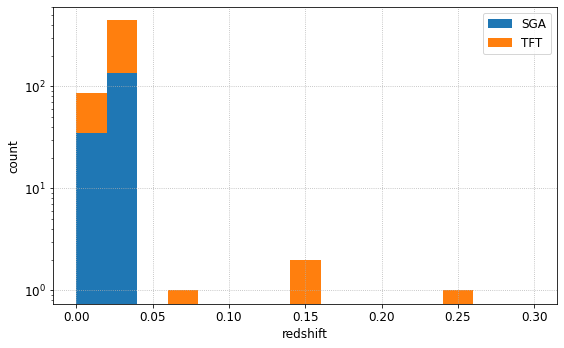

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []

pvtypes = np.unique(inComa_sga_table['PVTYPE'])

for pvtype in pvtypes:
    
    ispvtype = inComa_sga_table['PVTYPE'] == pvtype
    
    zdata.append(list(inComa_sga_table['Z'][ispvtype]))
    
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)

ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

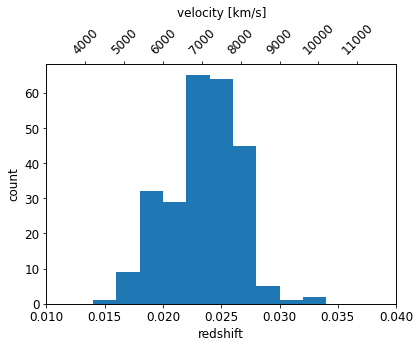

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

gal_center = (inComa_sga_table['TARGETID'] > 30000000000000000) & (inComa_sga_table['TARGETID'] < 40000000000000000)

ax.hist(inComa_sga_table['Z'][gal_center], bins=np.arange(0.01, 0.04, 0.002))
ax.set(xlim=(0.01, 0.04),
       xlabel='redshift',
       ylabel='count')

axv = ax.twiny()
z1, z2 = ax.get_xlim()
axv.set(xlim=(3e5*z1, 3e5*z2),
        xticks=np.arange(4000, 12000, 1000),
        xlabel='velocity [km/s]')
axv.set_xticklabels(axv.get_xticks(), rotation=45);

In [26]:
inComa_sga_table[inComa_sga_table['Z'] > 0.05]

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,479267,1083964303343616,193.212533494368,28.3565632611583,0,119,193.2125461919,28.3565714779669,0.647544493273577,2.32827951834562e-05,GALAXY,105.954223185778,0,SGA-2020 479267,UGC08017,43726,193.223256,28.3711396,Sab,32.77,0.9705099,0.40738028,0.023567302,23.19548,14.632,False,LEDA-20181114,173505,UGC08017,1,True,193.223256,28.3711396,0.9705099,1931p282,193.22326399137768,28.371257131764786,2.094384,SB26,32.711063,0.34135544,193.22326742853102,28.371391341529367,37.430275,16.382334,15.275859,13.699057,23.25637,26.789795,30.245378,33.21096,37.475143,42.346695,48.86669,55.77499,62.83152,14.549167,13.689457,12.987709,14.437251,13.602051,12.916058,14.353003,13.55935,12.879651,14.29725,13.526271,12.857021,14.265436,13.5007305,12.834833,14.243729,13.479929,12.816815,14.223234,13.456524,12.797661,14.211214,13.442772,12.7845125,14.200599,13.434463,12.774726,0.1548696,0.18797058,0.17119567,0.23171137,0.2245427,0.22079302,0.33477628,0.25752372,0.31800905,0.013410061,0.014817764,0.01566161,0.012719892,0.014070479,0.014943715,0.012220354,0.013655774,0.014534117,0.011855968,0.013340248,0.014272992,0.011578928,0.01306079,0.014007257,0.011369689,0.01282808,0.013787869,0.011161851,0.012574973,0.013553993,0.011043096,0.012419843,0.013393481,0.0109442705,0.01231589,0.01327469,14.19843

In [27]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39628443926662280.jpg exists.
cache/coma_39628443968603408.jpg exists.
cache/coma_39628433273127877.jpg exists.
cache/coma_39628433252157334.jpg exists.
Multiple observations of galaxy center for 811359
cache/coma_39628433256350922.jpg exists.
cache/coma_39628459865019729.jpg exists.
cache/coma_39628427904417920.jpg exists.
cache/coma_39628433268936617.jpg exists.
cache/coma_39628459890181137.jpg exists.


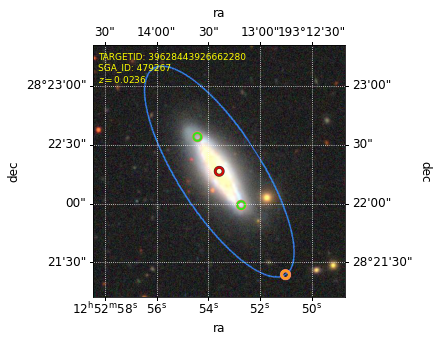

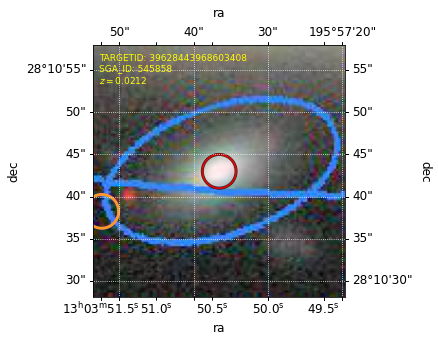

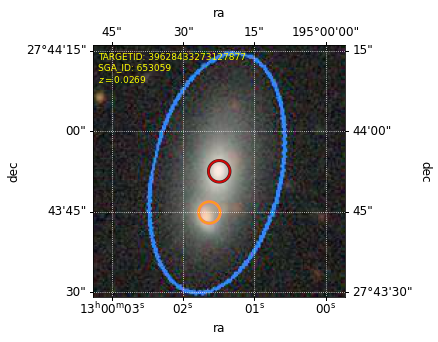

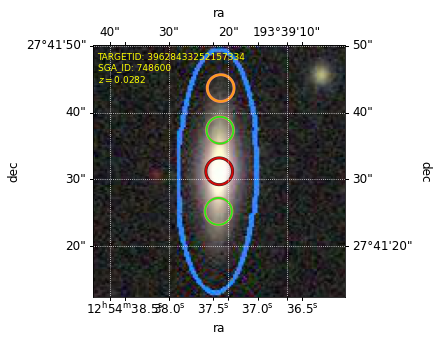

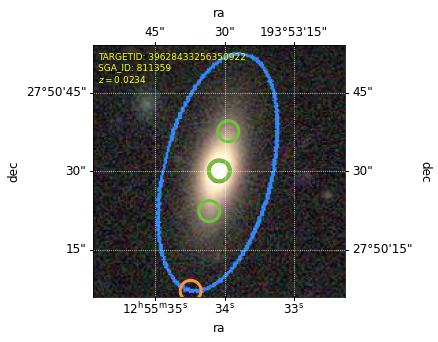

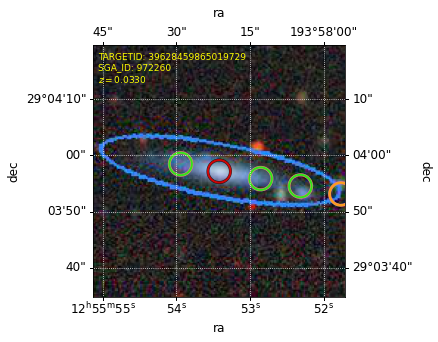

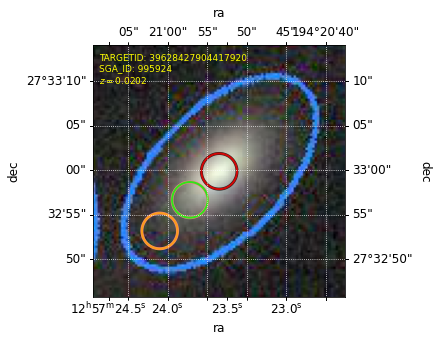

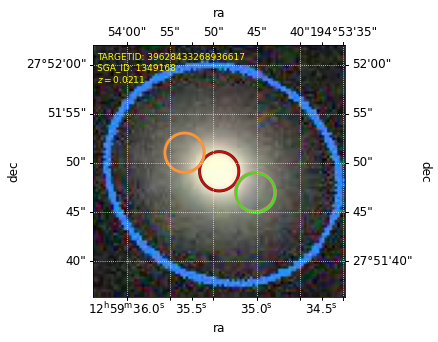

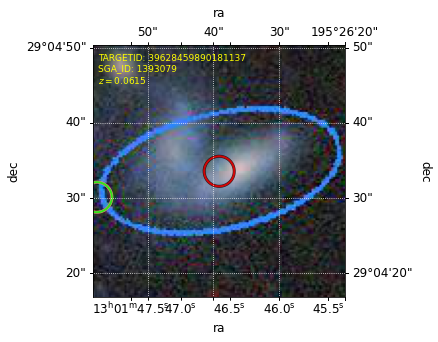

In [28]:
for sga_id in np.unique(inComa_sga_table['SGA_ID'][inComa_sga_table['Z'] > 0.05]):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    # Total hack to find SGA target, because the PVTYPE can't be trusted.
    # Talk to an expert about actual SGA targets in DESI.
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    '''
    if np.sum(is_sga_galaxy) < 1:
        print('No center observation of galaxy {}'.format(sga_id))
        continue
    ''';
    if np.sum(is_sga_galaxy) > 1:
        # Multiple observations of the center - just take the first one in the table
        print('Multiple observations of galaxy center for {}'.format(sga_id))
        sga_galaxy = sga_galaxy[0]
        '''
        print('Too many records for {}'.format(sga_id))
        continue
        ''';
        
    targetid = int(sga_galaxy['TARGETID'])
    ra, dec, z = float(sga_galaxy['FIBER_RA']), float(sga_galaxy['FIBER_DEC']), float(sga_galaxy['Z'])
    
    # D26 in arcmin
    d26 = float(SGA['D26'][SGA['SGA_ID'] == sga_id])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    #idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    '''
    isoffcenter = sep2d.to('arcsec') > 1.5*u.arcsec
    if np.sum(isoffcenter) == 0:
        print('No observations off the galactic center for {}'.format(sga_id))
        continue
    ''';
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig = plt.figure(figsize=(7,5))

    ax = fig.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the SDSS and DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])
        
        if tft['Z'] > 0.05:
            edgecolor2 = 'orange'
        else:
            edgecolor2 = 'lime'
        
        # Add the location of the SDSS and DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
    
    fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    fig.savefig('cache/coma_tf_{}.png'.format(targetid), dpi=120)
    
#     fig.clear()
#     plt.close(fig)

In [33]:
ids, counts = np.unique(inComa_sga_table['SGA_ID'], return_counts=True)
ids[counts > 10]

23552
104579
474614
730800
824392
1087419
1323268


25 observations of galaxy center for 23552
cache/coma_39628465158228317.jpg exists.
20 observations of galaxy center for 104579
cache/coma_39628443960217889.jpg exists.
cache/coma_39628438620865724.jpg exists.
9 observations of galaxy center for 730800
cache/coma_39628459869213257.jpg exists.
2 observations of galaxy center for 824392
cache/coma_39628417154419467.jpg exists.
12 observations of galaxy center for 1087419
cache/coma_39628427900226249.jpg exists.
2 observations of galaxy center for 1323268
cache/coma_39628438620868323.jpg exists.


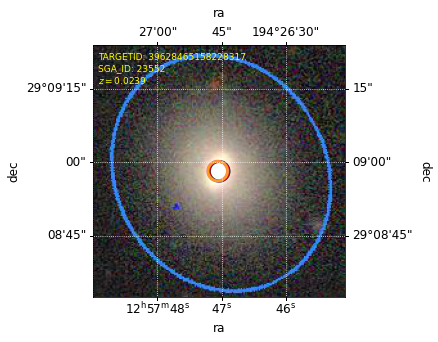

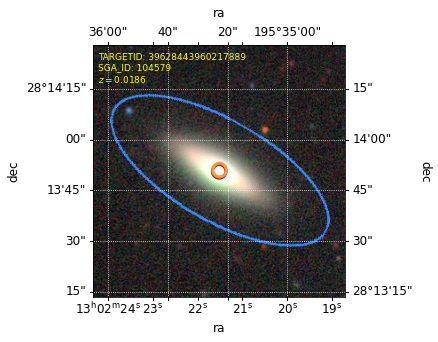

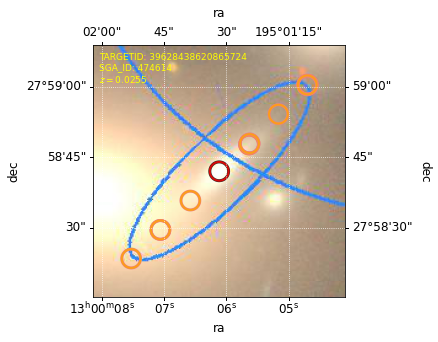

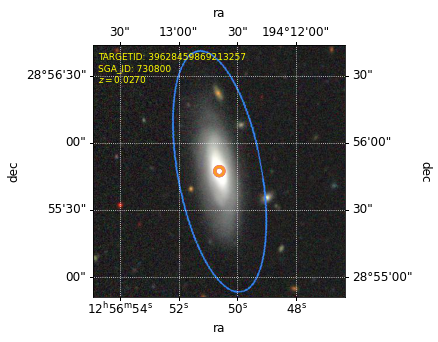

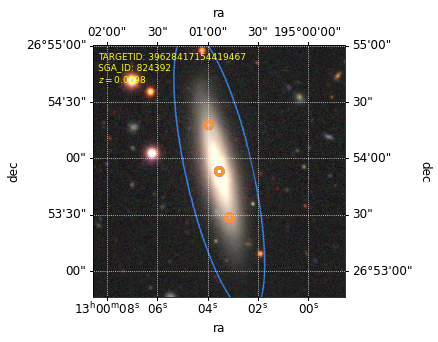

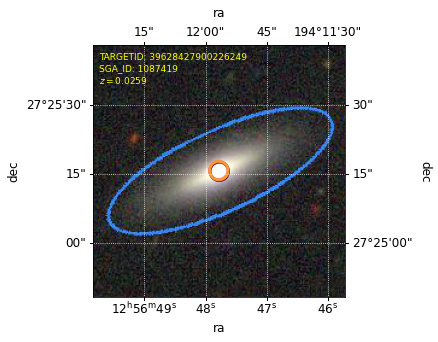

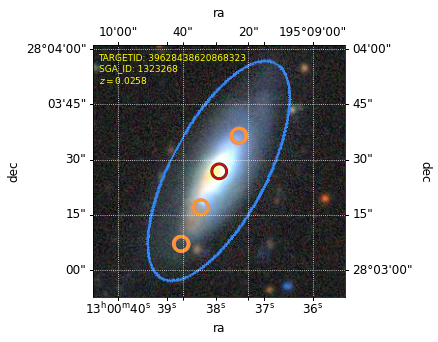

In [36]:
## Check images of galaxies with >10 observations

for sga_id in ids[counts > 10]:
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    # Total hack to find SGA target, because the PVTYPE can't be trusted.
    # Talk to an expert about actual SGA targets in DESI.
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    '''
    if np.sum(is_sga_galaxy) < 1:
        print('No center observation of galaxy {}'.format(sga_id))
        continue
    ''';
    if np.sum(is_sga_galaxy) > 1:
        # Multiple observations of the center - just take the first one in the table
        print('{} observations of galaxy center for {}'.format(np.sum(is_sga_galaxy), sga_id))
        sga_galaxy = sga_galaxy[0]
        '''
        print('Too many records for {}'.format(sga_id))
        continue
        ''';
        
    targetid = int(sga_galaxy['TARGETID'])
    ra, dec, z = float(sga_galaxy['FIBER_RA']), float(sga_galaxy['FIBER_DEC']), float(sga_galaxy['Z'])
    
    # D26 in arcmin
    d26 = float(SGA['D26'][SGA['SGA_ID'] == sga_id])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    #idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    '''
    isoffcenter = sep2d.to('arcsec') > 1.5*u.arcsec
    if np.sum(isoffcenter) == 0:
        print('No observations off the galactic center for {}'.format(sga_id))
        continue
    ''';
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig = plt.figure(figsize=(7,5))

    ax = fig.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the SDSS and DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the SDSS and DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
    
    fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
#     fig.savefig('cache/coma_tf_{}.png'.format(targetid), dpi=120)
    
#     fig.clear()
#     plt.close(fig)

<ipython-input-32-9d9899fe7e02>:8: RuntimeWarning: invalid value encountered in sqrt
  cosi = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))


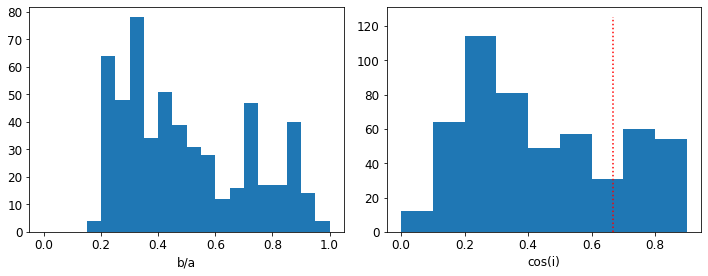

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.hist(inComa_sga_table['BA'], bins=np.arange(0,1.05,0.05))
ax.set_xlabel('b/a')

ax = axes[1]
cosi = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))
ax.hist(cosi, bins=np.arange(0,1,0.1))
ax.vlines(np.arccos(0.25*np.pi), 0,125, colors='r', linestyles=':')
ax.set_xlabel('cos(i)');

In keeping with what was done in Cosmicflows4, we will only keep those objects with $i > 45^\circ$ ($\cos(i) < \sqrt 2/2$).

In [33]:
mtypes, mcounts = np.unique(inComa_sga_table['MORPHTYPE'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

        5
E      42
E-S0   52
E?     22
I       5
S0     136
S0-a   59
S?     81
SABc   16
SBab    2
SBb     9
SBbc   12
SBc     8
Sa     10
Sab    13
Sb     21
Sbc     4
Sc     18
Scd    14
Sd      8
Sm      7


In [34]:
inComa_sga_table.write('cache/tf_targets_coma_sga.fits', overwrite=True)